# Real or Not? NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not  
[Kaggle Competetion]('https://www.kaggle.com/c/nlp-getting-started')

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

### Read Data

In [2]:
train_set = pd.read_csv('kaggle-NLP-train.csv')
test_set = pd.read_csv('kaggle-NLP-test.csv')

In [3]:
train_set.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_set.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
train_set.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Using regular expressions to clean the data.

In [6]:
def text_process(df, text):
    df[text] = df[text].str.replace(r"http\S+", "")
    df[text] = df[text].str.replace(r"http", "")
    df[text] = df[text].str.replace(r"@\S+", "")
    df[text] = df[text].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text] = df[text].str.replace(r"@", "at")
    df[text] = df[text].str.lower()
    return df

In [7]:
train_set = text_process(train_set, 'text')
test_set = text_process(test_set, 'text')

In [8]:
train_set.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,the out of control wild fires in california ...,1
7610,10871,NaN,NaN,m1 94 01 04 utc ?5km s of volcano hawaii,1
7611,10872,NaN,NaN,police investigating after an e bike collided ...,1
7612,10873,NaN,NaN,the latest more homes razed by northern calif...,1


In [56]:
test_set.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,"heard about earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


### Exploratory Data Analysis and Overview

In [9]:
train_set.groupby('target').describe()

id                                                           \
         count         mean          std   min      25%     50%     75%   
target                                                                    
0       4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1       3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                 
            max  
target           
0       10848.0  
1       10873.0

In [10]:
train_set.groupby('target').count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


Tokenization of the text column

In [11]:
from nltk.tokenize import RegexpTokenizer

In [12]:
train_set['tokens'] = train_set['text'].apply(RegexpTokenizer(r'\w+').tokenize)

In [13]:
train_set.head()

,id,keyword,location,text,target,tokens
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive wildfires evacuation or...",1,"[13, 000, people, receive, wildfires, evacuati..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala..."


### Vectorization
Now lets convert each text, represented as a list of tokens (lemmas) above, into a vector

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [15]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = train_set["text"].tolist()
list_targets = train_set["target"].tolist()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_targets, test_size=0.3,random_state=101)

In [17]:
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [57]:
test_set_count = count_vectorizer.transform(test_set["text"].tolist())

### Visualizing the embeddings

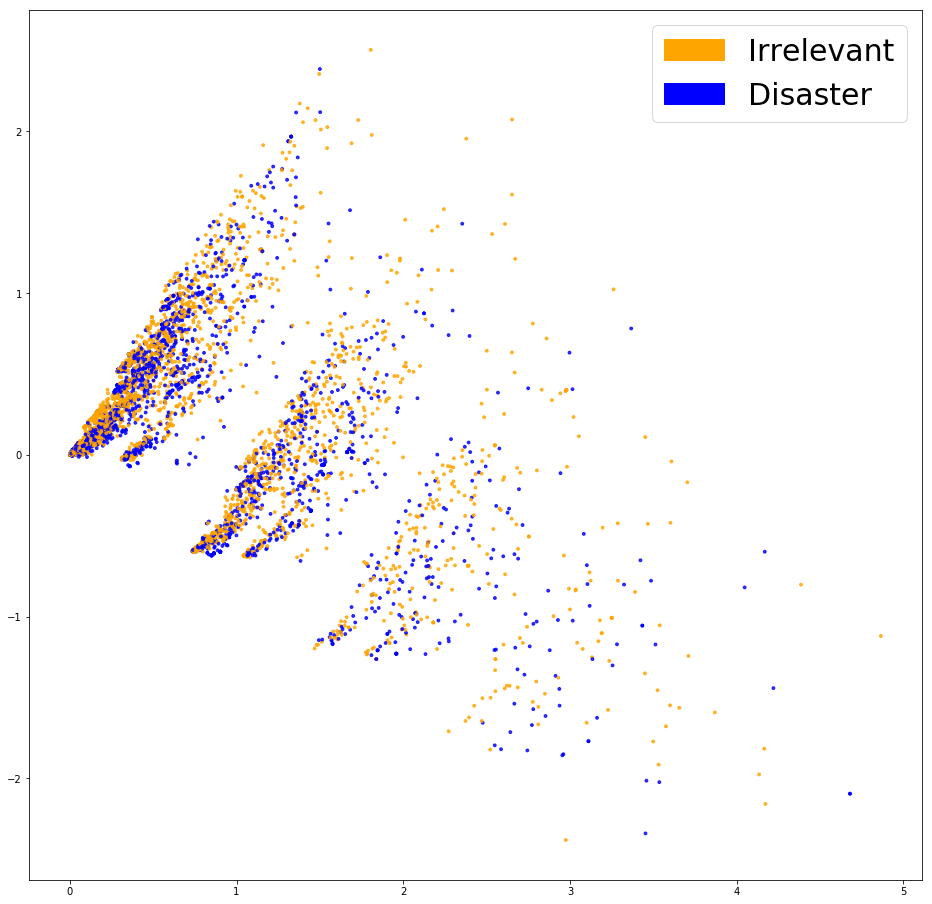

In [19]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_target, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_target))}
        color_column = [color_mapper[label] for label in test_target]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_target, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated.

### Fitting a Logistic Regression

**Get the best parameters using GridSearchCV**

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [21]:
#parameter grid

parameters={"C":[0.001, 0.01, 0.1, 1, 10, 30, 100, 1000], "penalty":["l2"], 'solver': ['newton-cg'], 'fit_intercept':[True,False], 'class_weight':['balanced'], 'random_state':[101], 'multi_class':['multinomial'] }

In [22]:
grid = GridSearchCV(LogisticRegression(), parameters, verbose=3, cv=10, n_jobs=-1)

In [23]:
grid.fit(X_train_counts, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   20.4s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 30, 100, 1000], 'penalty': ['l2'], 'solver': ['newton-cg'], 'fit_intercept': [True, False], 'class_weight': ['balanced'], 'random_state': [101], 'multi_class': ['multinomial']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [24]:
# View The Best Parameters
print('Best C:', grid.best_estimator_.get_params()['C'])
print('Best fit_intercept:', grid.best_estimator_.get_params()['fit_intercept'])
print("accuracy :",grid.best_score_)

Best C: 0.1
Best fit_intercept: True
accuracy : 0.7941452430099456


In [25]:
y_predicted_counts = grid.predict(X_test_counts)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [28]:
print(classification_report(y_test,y_predicted_counts))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1330
           1       0.77      0.73      0.75       954

   micro avg       0.80      0.80      0.80      2284
   macro avg       0.79      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



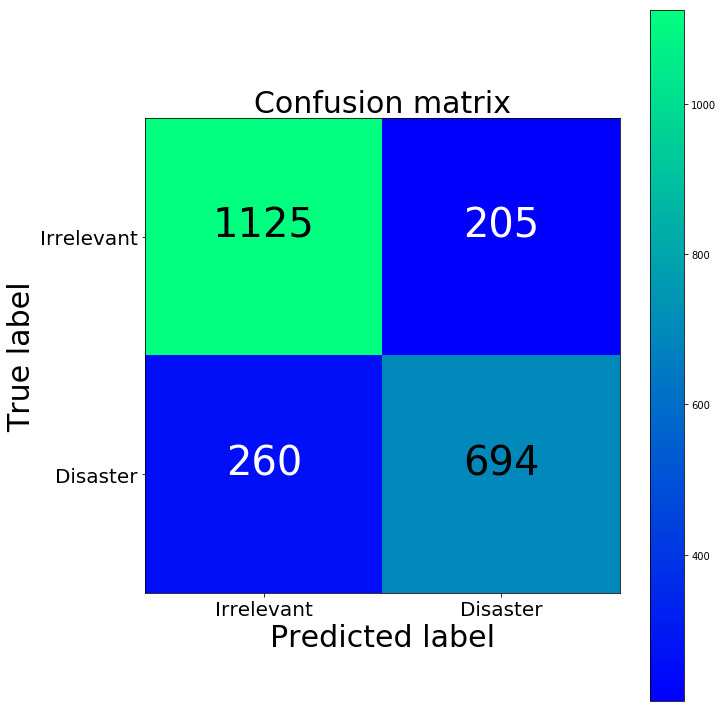

[[1125  205]
 [ 260  694]]


In [29]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

The false positive is pretty high and it could be a high cost to law enforcement for example.

### Further inspection into the classifier

In [30]:
clf = LogisticRegression(C=0.1, class_weight='balanced', solver='newton-cg', fit_intercept= True, multi_class='multinomial', n_jobs=-1, random_state=101)
clf.fit(X_train_counts, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=101, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [31]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

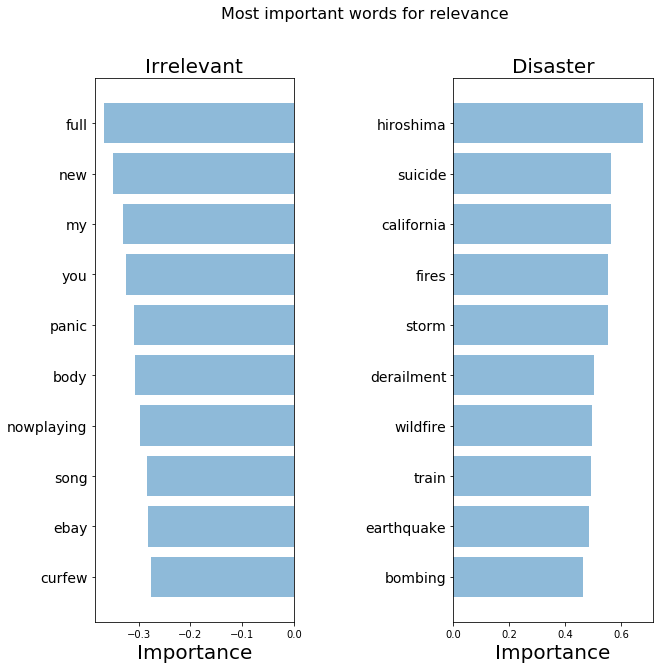

In [32]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The classifier currectly picks up on patterns, but also clearly seems to be overfitting on some irrelevant terms such as California

### TFIDF Bag of Words 

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

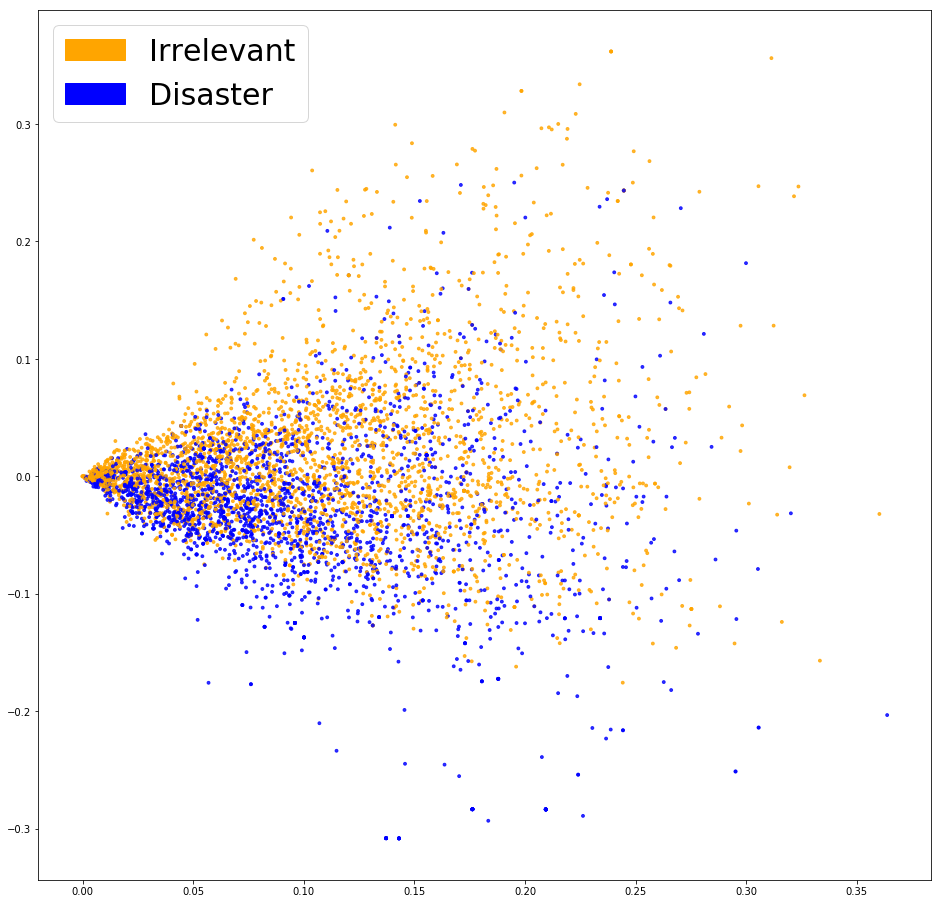

In [34]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

The embeding is more spread out than previous

In [35]:
clf_tfidf = LogisticRegression(C=0.1, class_weight='balanced', solver='newton-cg', fit_intercept= True, multi_class='multinomial', n_jobs=-1, random_state=101)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [36]:
print(classification_report(y_test,y_predicted_tfidf))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1330
           1       0.75      0.74      0.74       954

   micro avg       0.79      0.79      0.79      2284
   macro avg       0.78      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284



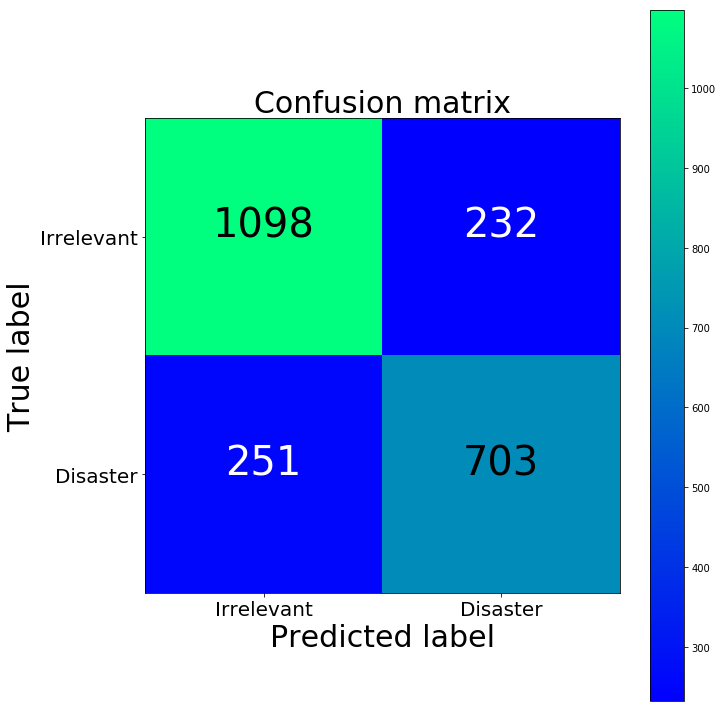

TFIDF confusion matrix
[[1098  232]
 [ 251  703]]
BoW confusion matrix
[[1125  205]
 [ 260  694]]


In [37]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

This model has increased our false positive

In [38]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

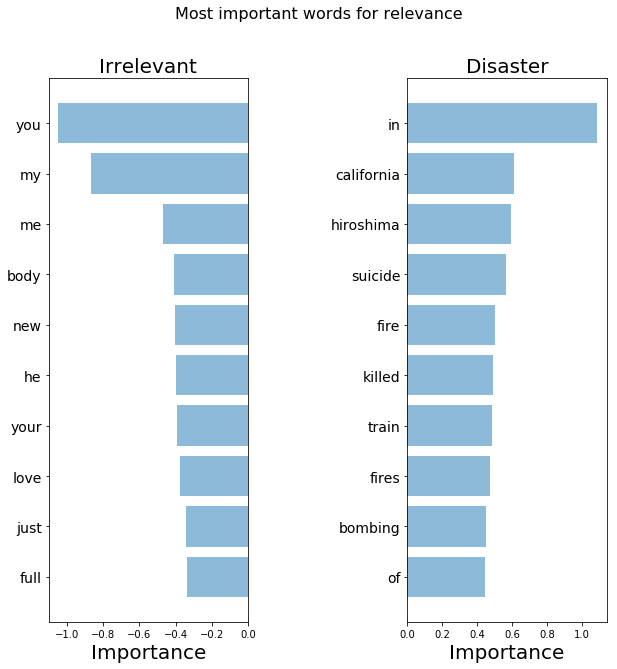

In [39]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

As we can see the model clearly seems to be overfitting on some irrelevant terms

### Capturing semantic meaning

In [40]:
import gensim

word2vec_path = "/Users/Cho/Desktop/Python/Refactored_Py_DS_ML_Bootcamp-master/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [52]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [53]:
embeddings = get_word2vec_embeddings(word2vec, train_set)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_targets,test_size=0.2, random_state=40)

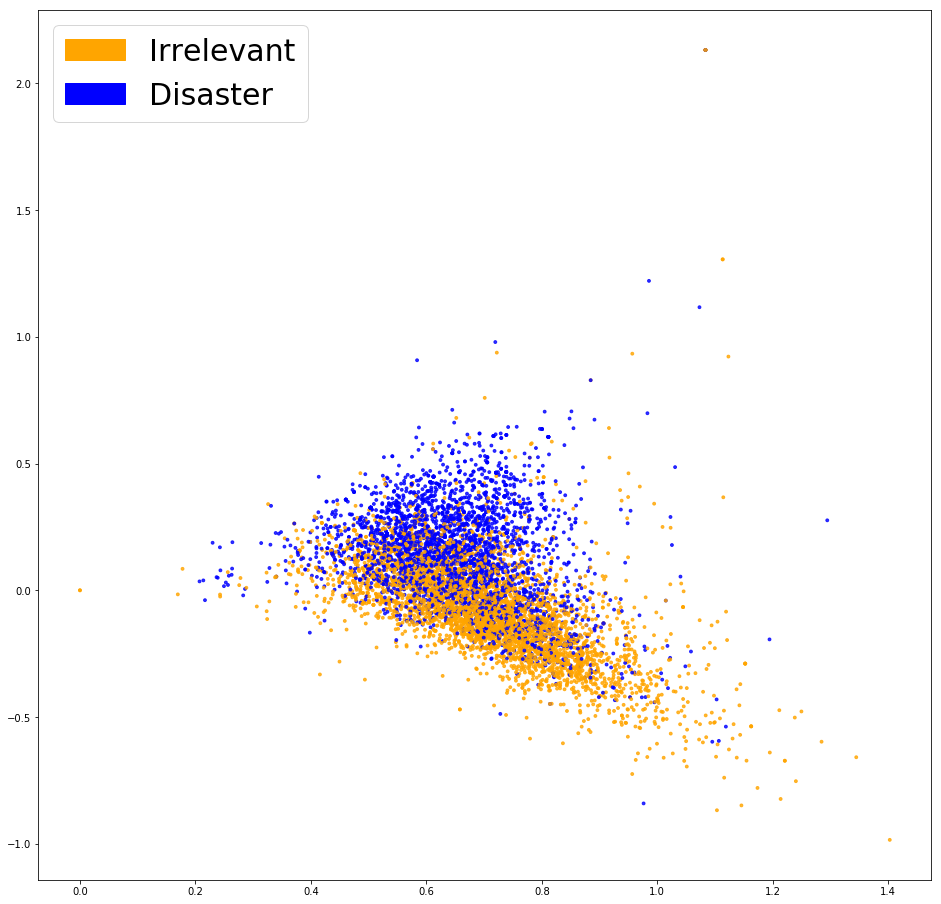

In [54]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_targets)
plt.show()

In [47]:
clf_w2v = LogisticRegression(C=0.1, class_weight='balanced', solver='newton-cg', fit_intercept= True, multi_class='multinomial', n_jobs=-1, random_state=101)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [48]:
print(classification_report(y_test_word2vec,y_predicted_word2vec))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1330
           1       0.76      0.75      0.75       954

   micro avg       0.80      0.80      0.80      2284
   macro avg       0.79      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



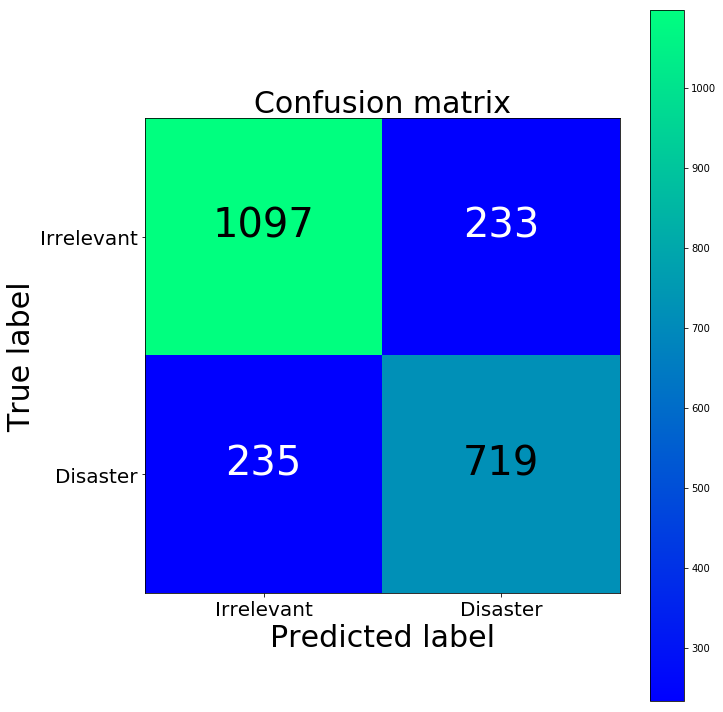

Word2Vec confusion matrix
[[1097  233]
 [ 235  719]]
TFIDF confusion matrix
[[1098  232]
 [ 251  703]]
BoW confusion matrix
[[1125  205]
 [ 260  694]]


In [49]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

**Predicting with test set**

In [60]:
predictions = grid.predict(test_set_count)

In [63]:
predictions[:100]

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [69]:
test_set.head(10)['text']

0                   just happened a terrible car crash
1    heard about  earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             apocalypse lighting   spokane  wildfires
4        typhoon soudelor kills 28 in china and taiwan
5                   we're shaking   it's an earthquake
6    they'd probably still show more life than arse...
7                                    hey! how are you?
8                                     what a nice hat?
9                                            fuck off!
Name: text, dtype: object

**Submission**

In [70]:
sample_submission = pd.read_csv("sample_submission.csv")

In [71]:
sample_submission["target"] = predictions

In [72]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [73]:
sample_submission.to_csv("submission.csv", index=False)